In [1]:
# new MA
import polars as pl
import numpy as np
import pandas as pd
from scipy import signal
import io
from scipy import ndimage
import matplotlib.pyplot as plt

def file_to_lazy_frame(filename):
    return pl.read_csv(filename, columns=['ts', 'z'], use_pyarrow=True).select([pl.col('ts').cast(pl.Datetime), pl.col('z').cast(pl.Int16)]).interpolate().filter(pl.col('ts').is_not_null()).filter(pl.col('z').is_not_null())

def get_filename(primary):
    return r"C:\Users\13103\Documents\data_analysis\PSG\rawdata\p5.csv"

xl0 = file_to_lazy_frame(get_filename(True))
xl1 = file_to_lazy_frame(get_filename(False))

# join data from each imu by the millisecond
xlz = xl0.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z0'}).join(xl1.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z1'}), on='ts', how='inner').select([pl.col('ts'), pl.col('z0').cast(pl.Int16), pl.col('z1').cast(pl.Int16)])

# convert into a pandas dataframe
df = xlz.to_pandas()
# convert into a pandas series
series = xlz.select(pl.col('z0')).to_series()

df = df.rename(columns={'z0': 'z'})
df['z'] = df['z']*2/9800
df['x'] = 0
df['y'] = 0
# df['ts'] = df ['ts']/10**6
# df.index = df['ts'].values.astype(np.int64)#CWT
df.index = pd.to_datetime(df['ts'].values.astype(np.int64))
csv = df['z']
csv.index = csv.index.values.astype(np.int64)


C:\Users\13103\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Z axis')

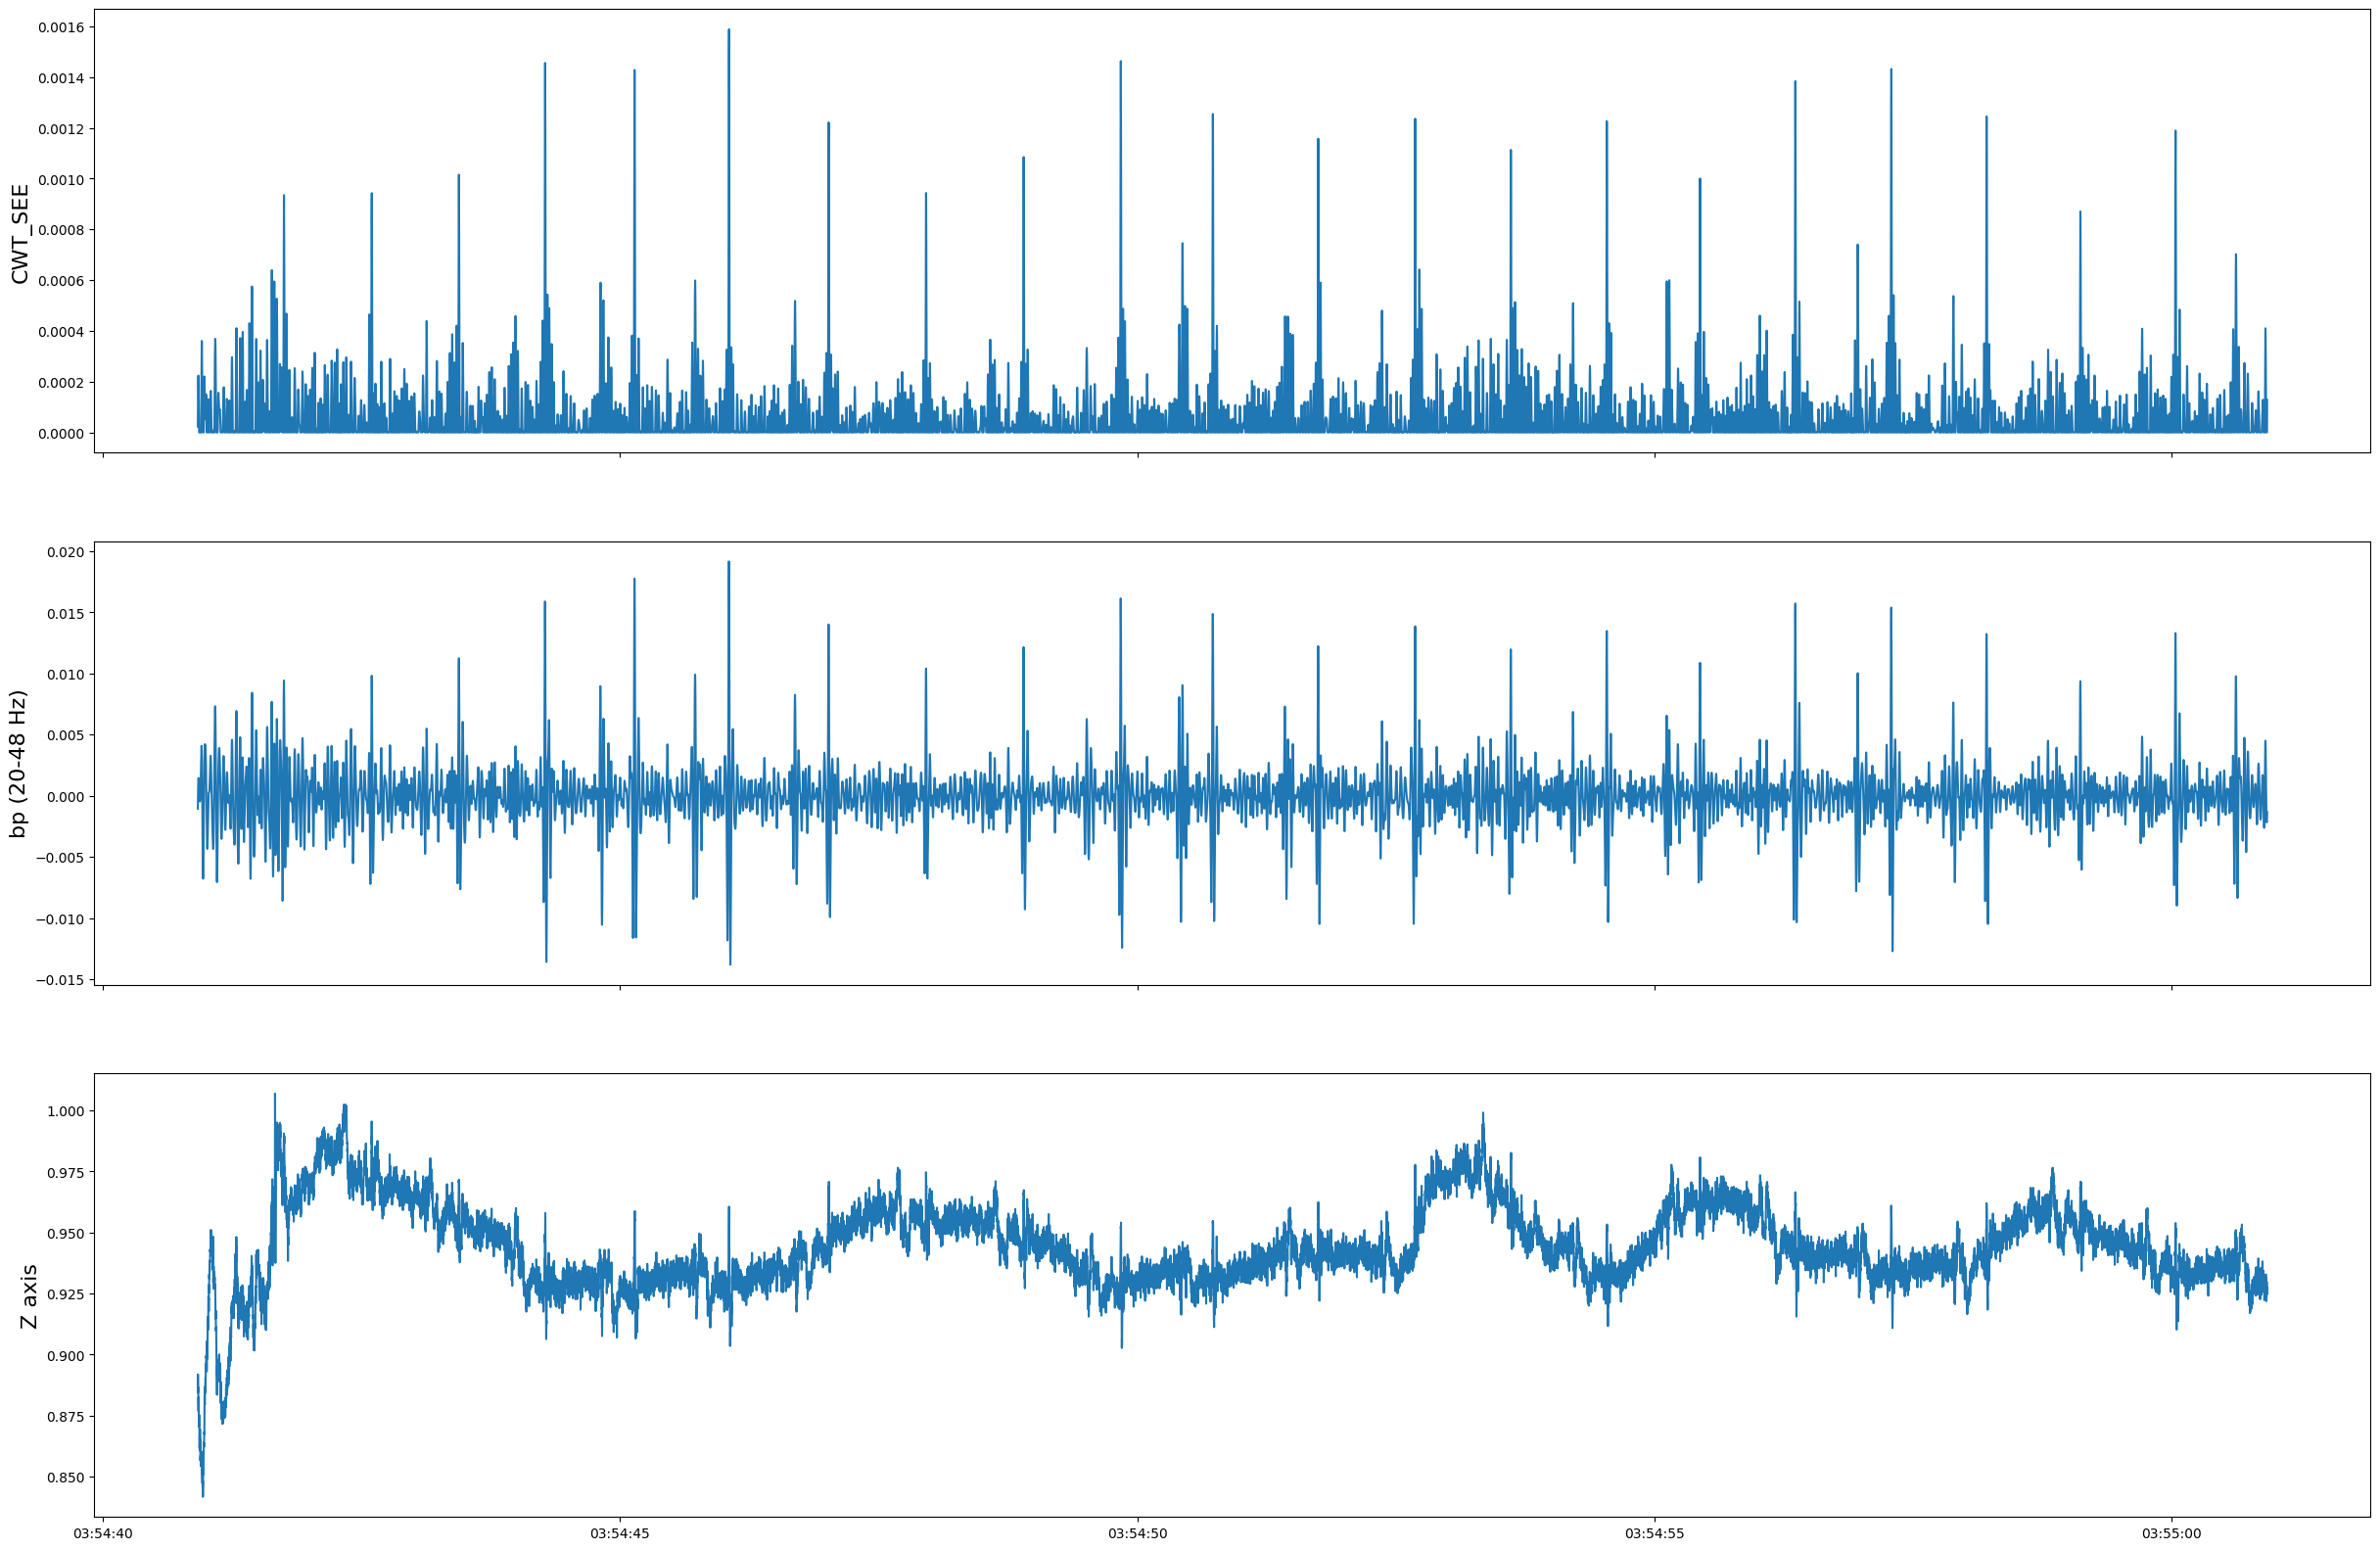

In [34]:
def shannon_energy(x):
    x_env = -x**2 * np.log(x**2)
    return(x_env)

# def bandpass_filt(sig,cutoff,fs,mode):
#     nyq = 0.5*fs
#     wn = cutoff/nyq
#     sos = signal.butter(4, wn, btype=mode,output='sos')
#     return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)
def bandpass_filt(sig,cutoff,fs,mode):
    nyq = 0.5*fs
    wn = cutoff/nyq
    sos = signal.butter(4, wn, btype=mode,output='sos')
    if isinstance(sig,pd.DataFrame):
        # if you gave in a dataframe, get it back with the appropriate columns
        return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)
    elif isinstance(sig,pd.Series):
        return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=[sig.name],index=sig.index)
    else:
        return signal.sosfiltfilt(sos,sig,axis=0)
#generate cwt matrix

fs = 1e-09**-1/np.median(np.diff(csv.index.values.astype(np.int64)))
csv = pd.DataFrame(csv)
test_bp = bandpass_filt(csv,(20,51),fs,'bandpass')
test_bp = test_bp.to_numpy().flatten()
cwtmtx = signal.cwt(test_bp,signal.morlet,np.arange(1,15))
tm = pd.to_datetime(csv.index)

## find cwt local maxiums 
# cwt_pk = cwtmtx.T[:,1:15]
cwt_pk = cwtmtx.T
cwt_pks = cwt_pk.max(axis=1)


#use shannon energy to process oscaliating signal
cwt_se = shannon_energy(cwt_pks)
cwt_se_gs = ndimage.gaussian_filter(np.abs(cwt_se),sigma=25)#40 is taken from the average heart sound lobe of 100ms 0.1*fs/4

fig, axs = plt.subplots(3,sharex=True,figsize=(30,20))

axs[0].plot(tm[3990000:4010000],cwt_pks[3990000:4010000])
axs[0].set_ylabel('CWT_SEE',fontsize=16)
axs[1].plot(tm[3990000:4010000],test_bp[3990000:4010000])
axs[1].set_ylabel('bp (20-48 Hz)',fontsize=16)
axs[2].plot(tm[3990000:4010000],csv[3990000:4010000])
axs[2].set_ylabel('Z axis',fontsize=16)

C:\Users\13103\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Z axis')

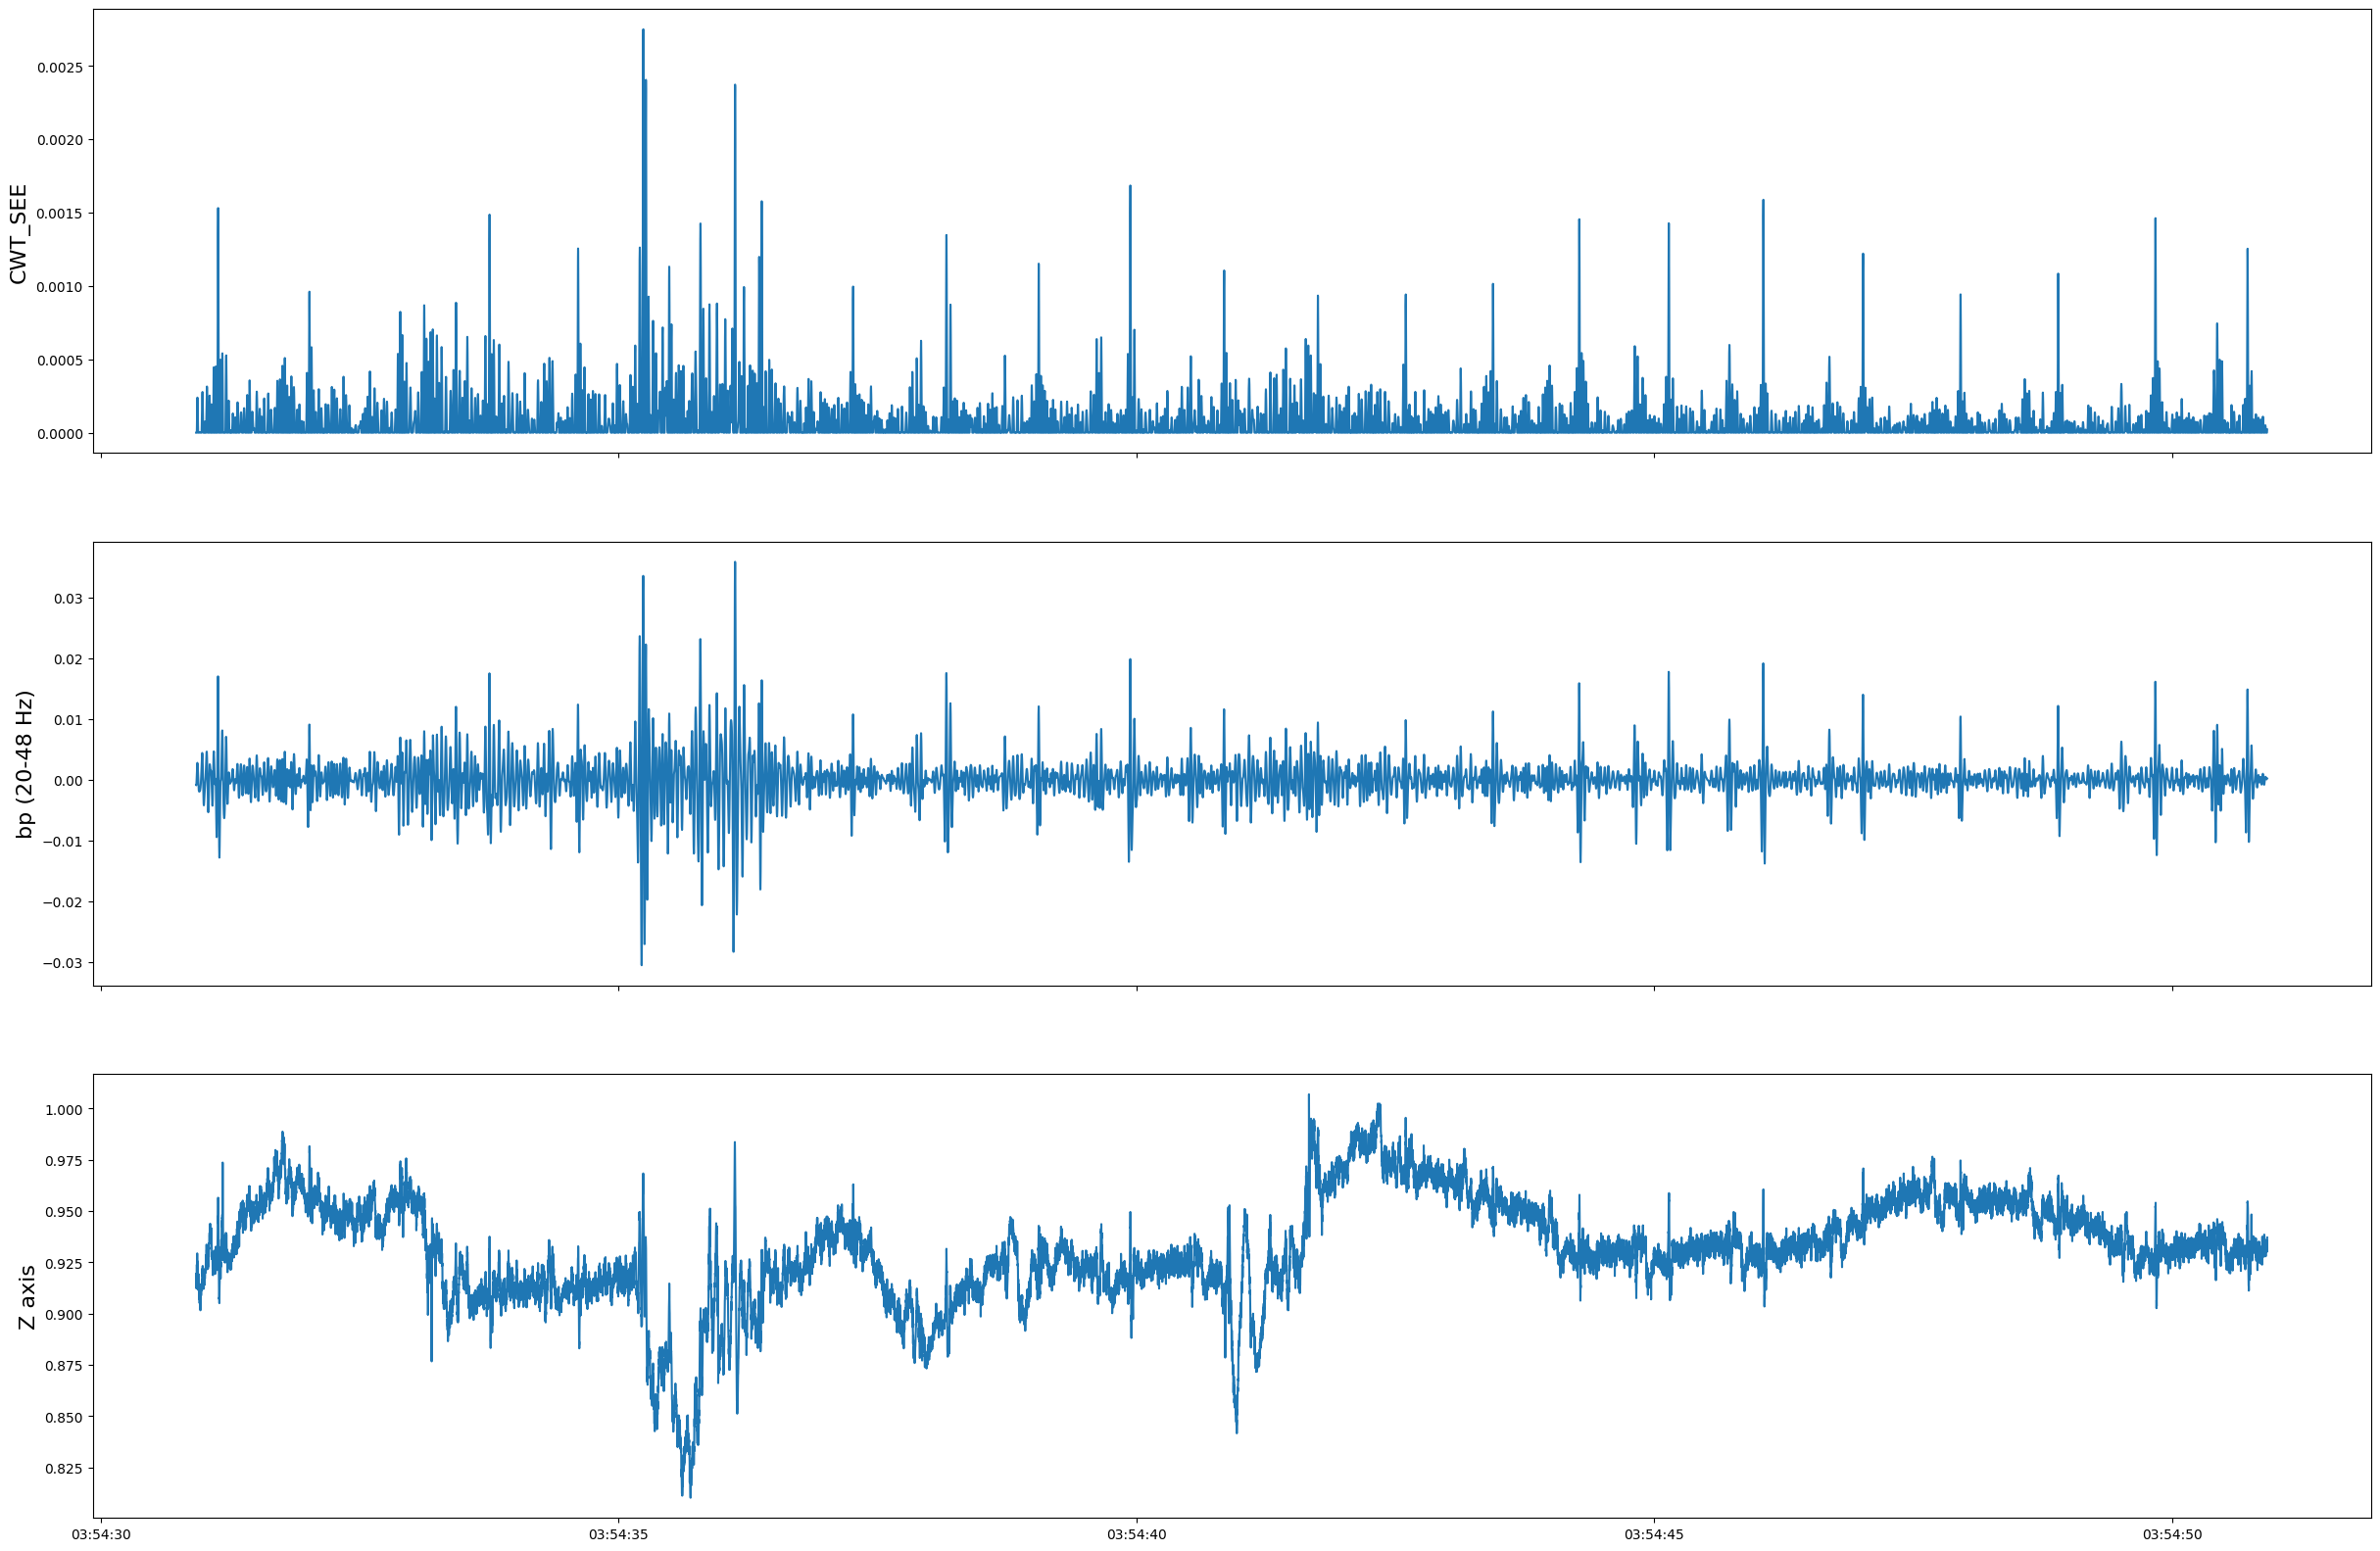

In [6]:
fig, axs = plt.subplots(3,sharex=True,figsize=(30,20))

axs[0].plot(tm[3980000:4000000],cwt_pks[3980000:4000000])
axs[0].set_ylabel('CWT_SEE',fontsize=16)
axs[1].plot(tm[3980000:4000000],test_bp[3980000:4000000])
axs[1].set_ylabel('bp (20-48 Hz)',fontsize=16)
axs[2].plot(tm[3980000:4000000],csv[3980000:4000000])
axs[2].set_ylabel('Z axis',fontsize=16)

In [23]:
merged_pks = bandpass_filt(cwt_se_gs,1/0.05,'lowpass')
peaks, _ = signal.find_peaks(cwt_se_gs,height=0.2*10**-5,distance=400)

hb_interval = np.diff(peaks)
filtered_hb_interval = bbi_filter(hb_interval)
hrvfeature,ma_rritv = hrv_generation(filtered_hb_interval,df,hb_interval)

inital length
636 outlier(s) have been deleted.
The outlier(s) value(s) are : [1254, 1212, 1213, 1207, 1364, 1289, 1295, 1239, 1239, 1215, 1437, 1203, 1379, 1241, 1313, 1358, 1264, 1237, 1339, 1339, 1229, 1201, 1211, 1223, 1226, 1341, 1283, 1224, 1233, 1204, 1249, 1243, 1352, 1343, 1368, 1487, 1359, 1295, 1327, 1351, 1246, 1376, 1297, 1430, 1313, 1288, 1332, 1335, 1267, 1258, 1279, 1272, 1214, 1395, 1380, 1242, 1413, 1395, 1262, 1289, 1259, 1230, 1274, 1271, 1321, 1272, 1330, 1248, 1350, 1300, 1212, 1237, 1310, 1328, 1234, 1287, 1331, 1226, 1280, 1249, 1242, 1266, 1270, 1222, 1255, 1346, 1258, 1241, 1209, 1224, 1226, 1357, 1421, 1259, 1212, 1438, 1318, 1378, 1269, 1309, 1363, 1260, 1246, 1344, 1266, 1259, 1279, 1276, 1268, 1258, 1267, 1260, 1258, 1266, 1285, 1344, 1364, 1426, 1298, 1269, 1271, 1284, 1289, 1261, 1284, 1355, 1303, 1375, 1201, 1321, 1244, 1288, 1353, 1261, 1318, 1272, 1314, 1314, 1286, 1267, 1264, 1415, 1235, 1286, 1314, 1258, 1291, 1339, 1206, 1221, 1227, 1304, 1280, 122

In [26]:
# sum(hb_interval)
sum(filtered_hb_interval)

27583890.166666664

In [ ]:
#interval calculation
peaks, _ = signal.find_peaks(cwt_se_gs,height=0.2*10**-5,distance=350)
itv_1 = peaks[0]
i = 0
hr = pd.DataFrame(columns=['index','Hr'])
while i < peaks.size-2:

    interval = peaks[i+2]-itv_1
    # itv_1 = peaks[i+2]
    # i = i+2
    if interval > 1200:
        interval = peaks[i+1]-itv_1
        if interval > 1200:
            interval = np.nan
        itv_1 = peaks[i+1]
        i = i+1
    else: 
        itv_1 = peaks[i+2]
        i = i+2
    

    hr_df = pd.DataFrame({'index': itv_1,'Hr':interval},index = [itv_1])
    hr = pd.concat([hr,hr_df])

hr.index = hr['index']
filtered_hr = hr[(hr['Hr']<1200) & (hr['Hr']>750)]
filtered_hr = fs/filtered_hr*60

In [ ]:
peaks, _ = signal.find_peaks(cwt_se_gs[3990000:4010000],height=0.2*10**-5,distance=350)
np.diff(peaks)
plt.figure(figsize=(20,5))
plt.plot(cwt_se_gs[3990000:4010000])
plt.plot(peaks, cwt_se_gs[3990000:4010000][peaks], "x")
plt.show()

In [41]:
import hrvanalysis as hrv
import scipy.signal as signal
def bbi_filter(beat_interval):
    #remove outliers
    print("inital length")

    filtered_interval = hrv.remove_outliers(beat_interval,low_rri = 400,high_rri = 1200)
    #Replace na values with linear interpolation using forier transfer
    interpolated_interval = hrv.interpolate_nan_values(filtered_interval,interpolation_method="linear")
    # This remove ectopic beats from signal
    # nn_intervals_list = hrv.remove_ectopic_beats(interpolated_interval, method="malik")
    # # This replace ectopic beats nan values with linear interpolation
    # interpolated_nn_intervals = hrv.interpolate_nan_values(nn_intervals_list)
    nn_intervals =  hrv.get_nn_intervals(interpolated_interval)
    return nn_intervals

def hrv_generation(peak_intervals,orign_df,rr_itv,binsize=120, mechano_acoustic = True):
    """ This function takes a peak peak interval list, bin size in second,a boolean, and the original dataset with time stamps as input, then will remove the abnormal intervals and heart beats and generate the HRV features.  """
   
    if mechano_acoustic:
        ma_df = orign_df
        
        itv_1 = 0
        itv_2 = 0
        i = 0
        k = 0
        hr = pd.DataFrame(columns=['index','Hr'])
        ma_it = pd.DataFrame(columns=['index','Hr'])
        hrv_feature = pd.DataFrame()
        while i < len(peak_intervals)-1:
            
            interval = peak_intervals[i]
            # itv_1 = peaks[i+2]
            i = i+1
            itv_2 = itv_2 + rr_itv[i]
            itv_1 = interval+itv_1
            k=k+interval
            hr_df = pd.DataFrame({'index': itv_2,'Hr':interval},index = [itv_2])
            hr = pd.concat([hr,hr_df])
            ma_it = pd.concat([ma_it,hr_df])
            if k > binsize*1000:
                bined_interval = hr.Hr.values.tolist()
                feature = pd.DataFrame([hrv.get_frequency_domain_features(bined_interval)])
                feature = pd.merge_asof(feature,pd.DataFrame([hrv.get_time_domain_features(bined_interval)]),left_index=True,right_index=True)
                feature = pd. merge_asof(feature,pd.DataFrame([hrv.get_geometrical_features(bined_interval)]),left_index=True,right_index=True)
                feature = pd. merge_asof(feature,pd.DataFrame([hrv.get_csi_cvi_features(bined_interval)]),left_index=True,right_index=True)
                # try:
                #     feature = pd.DataFrame([hrv.get_frequency_domain_features(bined_interval)])
                # except:
                #     print('feature error')
                itv_1 = int(itv_1)
                feature['time'] = ma_df.index[itv_2]
                hrv_feature = pd.concat([hrv_feature,feature],ignore_index=True)
                hr = pd.DataFrame(columns=['index','Hr'])
                k=0 
            
        ma_hrv = hrv_feature.copy()
        ##return ma_hrv, ma_it
        return ma_hrv,ma_it


In [42]:
hrvfeature,ma_rritv = hrv_generation(filtered_hb_interval,df,hb_interval)

In [30]:
df[-1:]

,ts,z,z1,x,y
2023-04-19 10:35:23.293,2023-04-19 10:35:23.293,-1.662857,-8148,0,0


In [26]:
sum(filtered_hb_interval)

27812302.0